# 1. EEG Dataset Processing

Scope:
- Process a raw EEG dataset & produce a results superset
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

The Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra (PSD) Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Results Superset - Collate & save the study, subject and EEG data into a results set, Pandas Dataframe


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- autoreject = 0.4.3
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

EEG Data Format for Processing:
- In FIF format (Functional Image File Format): https://www.perplexity.ai/search/having-read-some-eeg-data-usin-70hxIA1KSZu6VdV.MfLY_A

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


# Imports & Utilities

In [1]:
# Not availble through a Conda install/environment - PIP Install may be required
# %pip install specparam


In [2]:
# General imports
import os
import sys
import gc
import warnings

from datetime import datetime
from pprint import pprint
import time
import pickle
import random

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
from specparam import __version__ as specparam_version
print('Current SpecParam version:', specparam_version)


Current SpecParam version: 2.0.0rc3


In [3]:
# Print and also to add to a PDF file
#

def print_with_pdf(text, pdf_file):

    # Normal print
    print(text)

    # Text added to a PDF
    plt.figure(figsize=(12, 1))
    plt.axis('off') 
    # plt.text(0.01, 0.99, text, fontsize=14, va='top', ha='left', wrap=True, weight='bold')
    plt.text(0.01, 0.99, text, fontsize=14, va='top', ha='left', wrap=True)
    pdf_file.savefig()
    plt.close()


# Classes & Functions

## Get Raw EEG data

In [4]:
# Function to get the raw EEG signal data
#

def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
        try:
            eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
            sessions_eeg_raw.append(eeg_dataset_raw)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [5]:
# Function to save EEG data for a given subject
#

def save_EEG_for_subject(eeg_data, folder_path, subject_name, tag, epoched=False, format='fif', verbose=False):

    if epoched:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_epo.{format}')
    else:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_raw.{format}')

    if format == 'fif':
        eeg_data.save(subject_results_file, overwrite=False, verbose=verbose)
    elif format == 'set':
        mne.export.export_raw(subject_results_file, eeg_data, fmt='eeglab', overwrite=False, verbose=verbose)
    else:
        raise ValueError(f"Unsupported format: {format}")


In [6]:
# Function to plot EEG Time Series
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    # Time Range
    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        warnings.warn("Epoched data detected: plotting may not be accurate for all types.", UserWarning)
        return
        # signal, times = eeg_FIF.get_data(picks=channels)
        # times = eeg_FIF.times

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

## EEG Filtering & Referenceing

In [7]:
# Function to preprocess the raw EEG signal data
def perform_EEG_filtering(params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_filtered = EEG_raw.copy()

    # -----------------------------------------------------------------------
    # Bandpass filtering
    #
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=params['band_pass_lf'], 
                                       h_freq=params['band_pass_hf'], 
                                       method=params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # -----------------------------------------------------------------------
    # Montage Set
    # Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage("standard_1020")
    
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    missing_in_montage = raw_set - montage_set  
    EEG_filtered.drop_channels(missing_in_montage)

    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)

    # -----------------------------------------------------------------------
    # Remove linear trends from each channel signal & average
    #
    if params['linear_detrend'] != 'none':
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, 
                                    channel_wise=True, 
                                    type=params['linear_detrend'], 
                                    verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=params['channel_referencing'], verbose=flag_verbose)

    if flag_verbose:
        # std_1020_montage.plot()
        print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
        print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
        print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
        fig = EEG_filtered.plot_sensors(show_names=True)
        plt.show()

    return EEG_filtered


## Artefact Removal - ICA

In [8]:
# Function to perform artifact removal using ICS
def perform_artefact_removal(params, EEG_raw):
    """
    Artefact removal on the EEG raw data, using ICA

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    results : pd series
    epochs_ar : fif
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()
    quality_warning = False

    # -----------------------------------------------------------------------
    # Determine ICA components, label & identify for exclusion
    #

    # ICA & filter
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)
 
    ica_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ica_labels["labels"]
    brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    other_components = [i for i, label in enumerate(labels) if label != "brain"]
    filtered_ica = ica.apply(EEG_cleaned.copy(), exclude=np.unique(other_components), verbose=flag_verbose)

    # Flag 'quality'
    ICA_rejection_level = len(other_components)/ica.n_components_
    if ICA_rejection_level >= params['ICA_rejection_threshold']:
        warnings.warn(f"High component rejection: {100 * ICA_rejection_level:.2f}% marked as non-brain.", UserWarning)
        quality_warning = True

    if flag_verbose:
        print('ICA Components Breakdown')
        print(f'Original Channels: {len(EEG_cleaned.ch_names)}. ICA Components: {ica.n_components_}')
        print(f'Brain Components: {len(brain_components)}, {100 * len(brain_components)/ica.n_components_:.2f}%')
        print(f'Other Components: {len(other_components)}, {100 * len(other_components)/ica.n_components_:.2f}%')
        print(f'List of Brain components: {brain_components}')

        # Show the explained variance for top 5 components
        for component_idx in range(min(5, ica.n_components_)):
            component_variance = ica.get_explained_variance_ratio(EEG_cleaned, components=component_idx)
            print(f"Component {component_idx} contribution:", end=' ')
            for ch_type, variance in component_variance.items():
                print(f"  {ch_type}: {100 * variance:.2f}%")

        # ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")

    # -----------------------------------------------------------------------
    # Epoching & identify epochs for rejection
    #

    # Group the EEG signal into epochs and apply linear detrending
    epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0, preload=True, verbose=flag_verbose)
    epochs.apply_function(sci.signal.detrend, type='linear', verbose=flag_verbose)

    # Use autoreject to identify unusual large amplitudes in each epoch, drop these
    reject_criteria = get_rejection_threshold(epochs, verbose=flag_verbose)
    epochs.drop_bad(reject=reject_criteria, verbose=False)

    # Instantiate AutoReject and clean individual segments
    epochs_ar, reject_log = ar_model.fit_transform(epochs, return_log=True)
    epochs_ar.pick(['eeg'])
    n_epochs_rejected = np.sum(reject_log.bad_epochs)
    epochs_rejection_level = n_epochs_rejected / len(epochs)
    
    if flag_verbose:
        print(f'Epochs rejected: {n_epochs_rejected} out of {len(epochs)}, {100 * epochs_rejection_level:.2f}%')
        # TODO: Are these plots really of much use?
        # Epochs plot rejection patterns
        reject_log.plot('horizontal')
        # Before and After
        epochs.average().plot() 
        epochs_ar.average().plot() 

        print('EEG Post Artifact Removal')
        print(epochs_ar)

    # -----------------------------------------------------------------------
    # Collate results
    #
    results = pd.Series({
        'EEG_processing_quality_warning': quality_warning,
        'channel_count': len(EEG_raw.ch_names),
        'ICA_components_count': ica.n_components_,
        'ICA_rejection_level': ICA_rejection_level,
        'epochs_count': len(epochs),
        'epoch_rejection_level': epochs_rejection_level
        })
    
    return results, epochs_ar


## Get the Power Spectra

In [9]:
# Function to get the power spectra from the cleaned/preprocessed EEG signal data
#

def get_spectra(psd_params, EEG_clean):
    """
    Obtain the Power Spectra for all channels

    Parameters
    ----------
    psd_params : dic
    EEG_clean : fif

    Returns
    -------
    Spectra : frequencies and powers for each channel
    """

    # NB: PSD defaults to Welch for continuous, Multitaper for epoched data, here will typically force to Welch
    # TODO:  https://pmc.ncbi.nlm.nih.gov/articles/PMC6088222/

    psd = EEG_clean.compute_psd(method=psd_params['method'],
                                      fmin=psd_params['fmin'],
                                      fmax=psd_params['fmax'],exclude=psd_params['exclude'])
    
    # Average the PSD accross epochs
    if (isinstance(EEG_clean, mne.Epochs) and hasattr(EEG_clean, 'events')):
        psd = psd.average()

    # try:
    #     spectra_result = EEG_clean.compute_psd(method=psd_params['method'],
    #                                            fmin=psd_params['fmin'],
    #                                            fmax=psd_params['fmax'],
    #                                            exclude=psd_params['exclude'])
    # except Exception as e:
    #     raise Exception(f"Error calculating spectra: {e}")

    return psd


In [10]:
# Function to plot EEG Frequncy Domain / PSD
def plot_EEG_PSD(spectra, channel):
    """
    EEG Frequency Domain / PSD Plot.

    Parameters
    ----------
    spectra : mne.Spectrum
    channel : str eg 'P5'
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    # print('Quick PSD')
    # spectra.plot()
    # plt.show()

    # Log-log plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
        plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Log) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # Log-lin plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
         plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Lin) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # A selected channel
    ch_label = channel
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Power Spectrum - Channel {ch_label} ({spectra.method} method)', fontsize=20)
    ax0.set_title('Log/Log')
    ax1.set_title('Log/Lin')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
    plt.show()


## Spectral Parameterisation

In [11]:

# # Validate the quality of the SpecParam group fits
# fit_warning = False
# r2_threshold = 0.90

# spectra_n = len(fg)
# null_fits = fg.n_null_
# if null_fits > 0:
#     warnings.warn(f'Fits Failed: {null_fits} out of {spectra_n}', UserWarning)
#     fit_warning = True

# r2s = fg.get_params('r_squared')
# mean_r2 = r2s.mean()
# std_r2 = r2s.std()
# if mean_r2 < r2_threshold:
#     warnings.warn(f'SpecParam R2 mean {mean_r2:.2f} & std {std_r2:.2f}', UserWarning)
#     fit_warning = True

# print(fit_warning)

# mean_peaks = len(fg.get_params('peak_params')) / spectra_n
# print(f'Spectra: {spectra_n} with mean peaks {mean_peaks:.2f}')

In [12]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
#

def perform_SpecParam(specparam_params, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    specparam_params : dic
    spectra : spectra

    Returns
    -------
    group_summary : pd series of group fit summary
    specparam_df : dataframe of components for each channel
    fg : SpectralGroup Model
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    # Initialise SpecParam Group Model & fit it
    fg = SpectralGroupModel(peak_width_limits=specparam_params['peak_width_limits'], 
                                max_n_peaks=specparam_params['max_n_peaks'], 
                                min_peak_height=specparam_params['min_peak_height'],
                                peak_threshold=specparam_params['peak_threshold'],
                                aperiodic_mode=specparam_params['aperiodic_mode'])
    fg.fit(freqs, powers, specparam_params['fit_freq_range'], progress='tqdm.notebook', n_jobs=-1)

    # spm_fit_freq_range = [1, 75]
    # try:
    #     fg = SpectralGroupModel(peak_width_limits=specparam_params['peak_width_limits'], 
    #                             max_n_peaks=specparam_params['max_n_peaks'], 
    #                             min_peak_height=specparam_params['min_peak_height'],
    #                             peak_threshold=specparam_params['peak_threshold'],
    #                             aperiodic_mode=specparam_params['aperiodic_mode'])
    #     fg.fit(freqs, powers, specparam_params['fit_freq_range'], progress='tqdm.notebook')
    # except Exception as e:
    #     raise Exception(f"Error performing SpecParam: {e}")



    # Check the quality of SpecParam Group fits
    fit_warning = False

    spectra_n = len(fg)
    null_fits = fg.n_null_
    if null_fits > 0:
        warnings.warn(f'Fits Failed: {null_fits} out of {spectra_n}', UserWarning)
        fit_warning = True

    r2s = fg.get_params('r_squared')
    mean_r2 = r2s.mean()
    std_r2 = r2s.std()
    if mean_r2 < specparam_params['fit_r2_threshold']:
        warnings.warn(f'SpecParam R2 mean {mean_r2:.2f} & std {std_r2:.2f}', UserWarning)
        fit_warning = True

    mean_peaks = len(fg.get_params('peak_params')) / spectra_n

    group_summary = pd.Series({
        'SPM_fit_quality_warning': fit_warning,
        'spectra_count': spectra_n,
        'null_fits': null_fits,
        'r2_mean': mean_r2,
        'peaks_mean': mean_peaks
        })

    # Create a results dataframe
    specparam_df = fg.to_df(specparam_params['max_n_peaks'])   

    
    return group_summary, specparam_df, fg


In [13]:
# Function to plot SpecParam Results
def plot_SpecParam(fg, channel_indx, channel_name):
    """
    EEG SpecParam Results Plot

    Parameters
    ----------
    fg : SpecParamGroupModel
    """
    fm = fg.get_model(ind=channel_indx, regenerate=True)

    print(f'SpecParam for Channel: {channel_name}')
    fm.print_results()

    # fm.plot()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    fig.suptitle(f'Spec Param for Channel: {channel_name}', fontsize=20)
    ax0.set_title('Components - Log/Lin')
    ax1.set_title('Components - Log/Log')
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
    plt.show()


## Results Collate

In [14]:
# Collate Results for a subject
def subject_results_combine(subject_details, artefact_results, group_summary, specparam_results_df):
    """
    Results collate for an indvidual subject

    Parameters
    ----------
    subject_details : pd series
    artefact_results : pd series
    group_summary : pd series
    specparam_results_df : df
    Returns
    -------
    subject_results_df: df (single row)
    """

    subject_results_df = pd.concat([subject_details, artefact_results, group_summary]).to_frame().T
    subject_results_df = subject_results_df.infer_objects()

    # Results Add
    rows = [subject_results_df]
    for idx, row in specparam_results_df.iterrows():
        row_df = pd.DataFrame([row.values], columns=[f'chn_{idx}_{col}' for col in row.index])
        rows.append(row_df)
    subject_results_df = pd.concat(rows, axis=1, ignore_index=False)

    return subject_results_df

In [15]:
def display_file_summary(data_frame, name=""):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate Data Types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                #  'Top': data_frame.apply(lambda x: x.value_counts().index[0]),
                                #  'Freq': data_frame.apply(lambda x: x.value_counts().iat[0]),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'Bool': 0, 'List': 0, 'Other': 0
                                 })
    # ?? Below with Map should not work as counting entire data frame, but counts do appear correct
    #test = data_frame['Description'].apply(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['Bool'] = data_frame.map(lambda cell: isinstance(cell, bool)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()
    summary_of_df['Other'] = data_frame.map(lambda cell: isinstance(cell, (tuple,dict,set,type(None)))).sum()

    print(f'File Details. {name}')
    display(summary_of_df)

# Study & Run Parameters Define

In [16]:
# EEG Processing Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest_New'
dataset_ref = 'ds004584-1.0.0'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'

# Run/Test Mode
test_mode = True
run_name = 'test_full_process'

# Execution Parameters
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 
                     'band_pass_method': 'iir', 'phase': 'zero',
                     'linear_detrend': 'linear',  # linear, none
                     'channel_referencing': 'average'
                     }
artefact_params = {'ica_method': 'infomax', # infomax, none
                   'ICA_rejection_threshold': 0.8
                   }
psd_params = {'method': 'welch', #welch or multitaper (often used for epoched data)
              'fmin': 1, 'fmax': 100,       
              'exclude': []  # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 100],
                    'fit_r2_threshold': 0.9
                     }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
dataset_path = study_info['dataset_path']
eeg_processing_results_path = study_info['eeg_processing_results_path']
ml_training_results_path = study_info['ml_training_results_path']

# Establish a new EEG Processing Run
current_date = datetime.now().strftime('%Y%m%d')
eeg_run_id = f'EEG_Processing_{dataset_ref}_{current_date}_{run_name}'
eeg_processing_run_path = utils.extend_folder_path(eeg_processing_results_path, eeg_run_id, exists_ok=False)
results_pdf = PdfPages(os.path.join(eeg_processing_run_path, 'results.pdf'))

# Create run df and save
# eeg_run_params_df = pd.DataFrame({
#     'eeg_run_id': eeg_run_id,
#     'study_name': study_name,
#     'dataset_ref': dataset_ref,
#     'preprocess_params': preprocess_params,
#     'artefact_params': artefact_params,
#     'psd_params': psd_params,
#     'specparam_params': specparam_params,
# })
# eeg_run_params_df.to_pickle(eeg_processing_run_path + '/eeg_run_params_df.pkl', compression='zip')
eeg_run_params = pd.Series({
    'eeg_run_id': eeg_run_id,
    'study_name': study_name,
    'dataset_ref': dataset_ref,
    'preprocess_params': preprocess_params,
    'artefact_params': artefact_params,
    'psd_params': psd_params,
    'specparam_params': specparam_params,
})
eeg_run_params.to_pickle(eeg_processing_run_path + '/eeg_run_params.pkl', compression='zip')

# Create empty study results
eeg_results_superset_df = pd.DataFrame()

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    test_subjects = [1,25]
    test_channels = ['P5', 'C4', 'Cz']
else:
    VERBOSE = False
    test_subjects = []
    test_channels = []

del current_date, eeg_processing_results_path

# Execute EEG Processing Run

EEG Processing for: IOWA_Rest_New ds004584-1.0.0. Run: test_full_process
- Preprocessing Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
- Artefact Removal Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}
- PSD Params: {'method': 'welch', 'fmin': 1, 'fmax': 100, 'exclude': []}
- Specparam Params: {'peak_width_limits': [1, 12], 'max_n_peaks': 10, 'min_peak_height': 0.1, 'peak_threshold': 2.0, 'aperiodic_mode': 'fixed', 'fit_freq_range': [1, 100], 'fit_r2_threshold': 0.9}

-----------------------------------------------------------------------------------------------
Subject: sub-002
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-002/eeg/sub-002_task-Rest_eeg.fdt
Reading 0 ... 163019  =      0.000 ...   326.038 secs...


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_96860/988434826.py:46: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Description: None on None
<RawEEGLAB | sub-002_task-Rest_eeg.fdt, 63 x 163020 (326.0 s), ~78.4 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
Raw EEG Signal


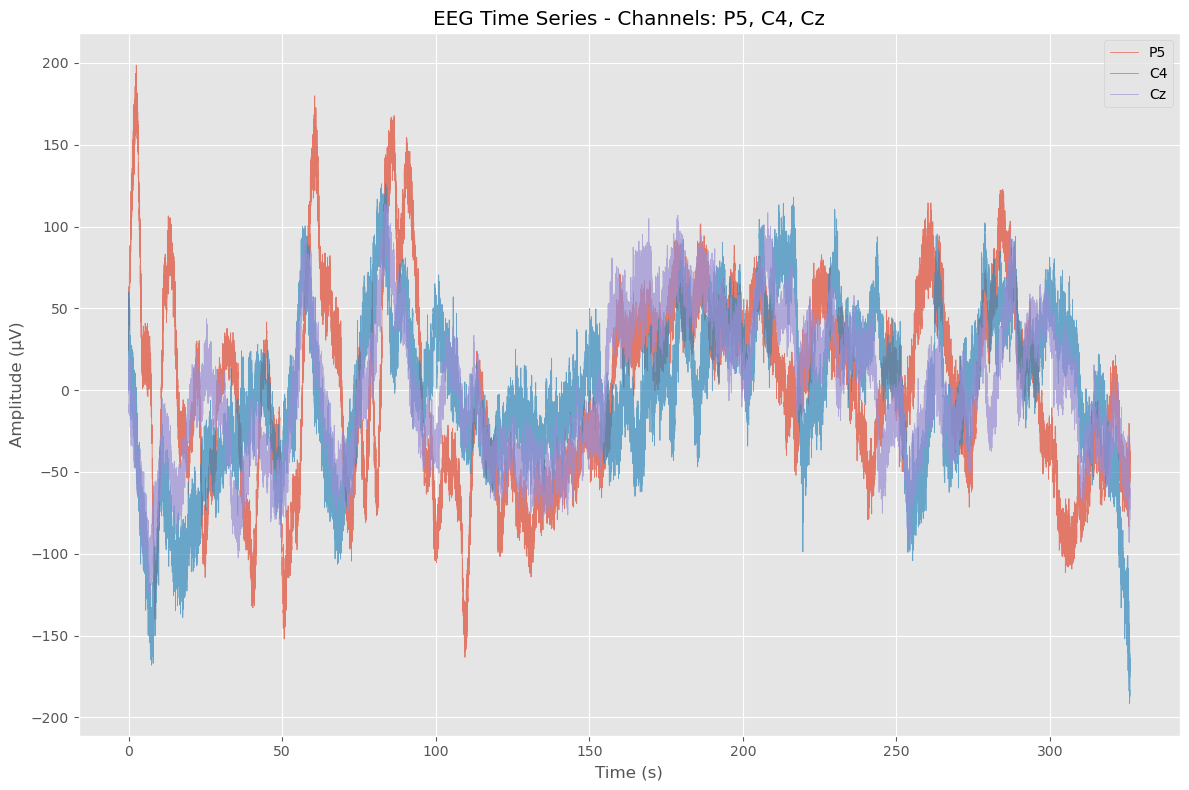

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    1.7s finished


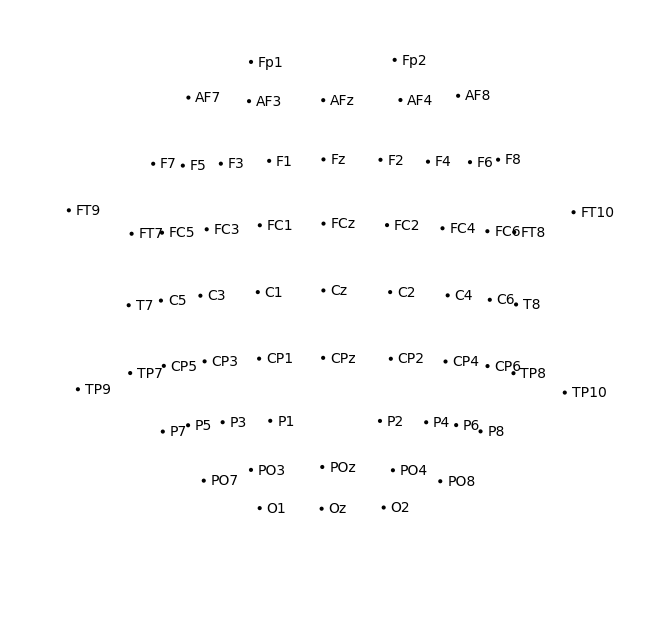

Filtered EEG Signal


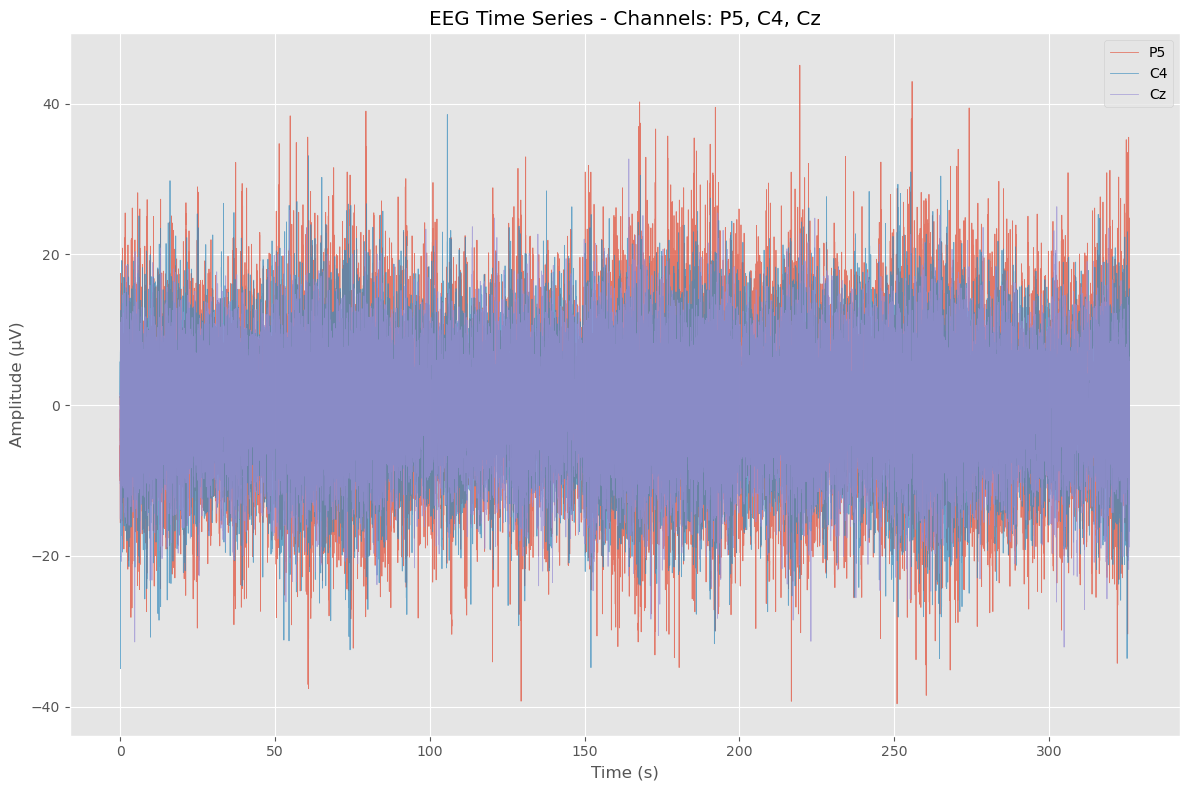

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA
Fitting ICA took 63.1s.
Applying ICA to Raw instance
    Transforming to ICA space (62 components)
    Zeroing out 22 ICA components
    Projecting back using 63 PCA components
ICA Components Breakdown
Original Channels: 63. ICA Components: 62
Brain Components: 40, 64.52%
Other Components: 22, 35.48%
List of Brain components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 28, 30, 31, 34, 36, 38, 41, 44, 45, 48, 51, 52, 53, 57, 58, 60, 61]
Component 0 contribution:   eeg: 8.69%
Component 1 contribution:   eeg: 8.24%
Component 2 contribution:   eeg: 7.38%
Component 3 contribution:   eeg: 6.30%
Component 4 contribution:   eeg: 6.29%
Not setting metadata
326 matching events found
No baseline correction applied
0 projection items activated
Us

  0%|          | Creating augmented epochs : 0/63 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/63 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=8


  0%|          | Repairing epochs : 0/326 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Epochs rejected: 0 out of 326, 0.00%


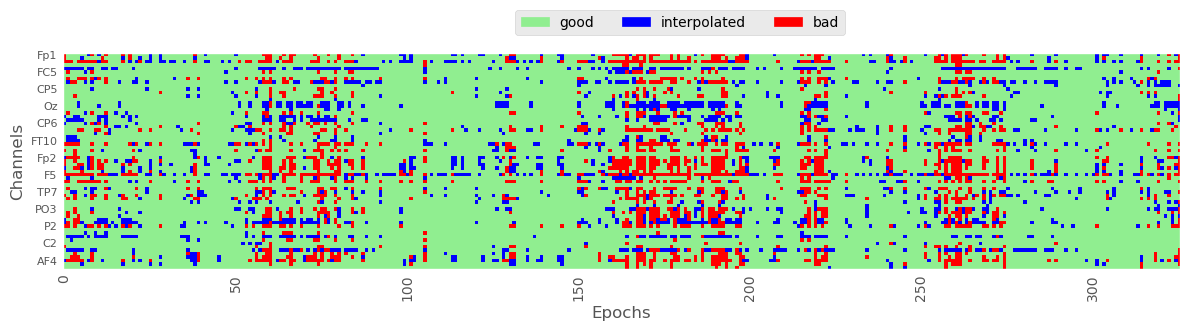

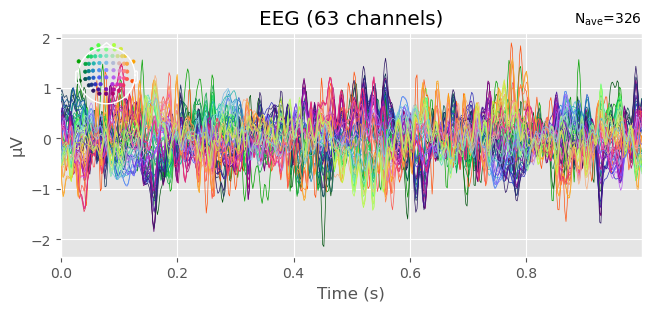

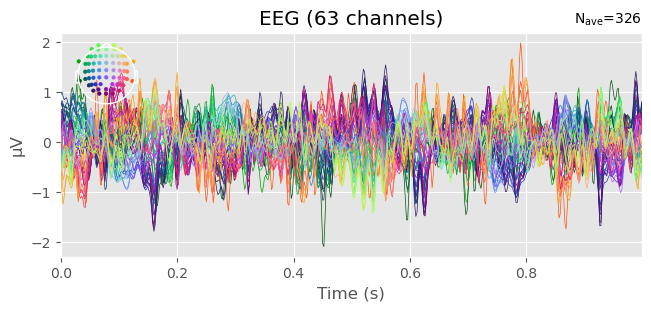

EEG Post Artifact Removal
<Epochs | 326 events (all good), 0 – 0.998 s (baseline off), ~78.4 MiB, data loaded,
 '1': 326>
Temp .... <Epochs | 326 events (all good), 0 – 0.998 s (baseline off), ~78.4 MiB, data loaded,
 '1': 326>, 
EEG_processing_quality_warning       False
channel_count                           63
ICA_components_count                    62
ICA_rejection_level               0.354839
epochs_count                           326
epoch_rejection_level                  0.0
dtype: object
---Power Spectra----------------------------------------------------
Effective window size : 1.000 (s)
<Averaged Power Spectrum (from Epochs, welch method) | 63 channels × 100 freqs, 1.0-100.0 Hz>
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: True
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>


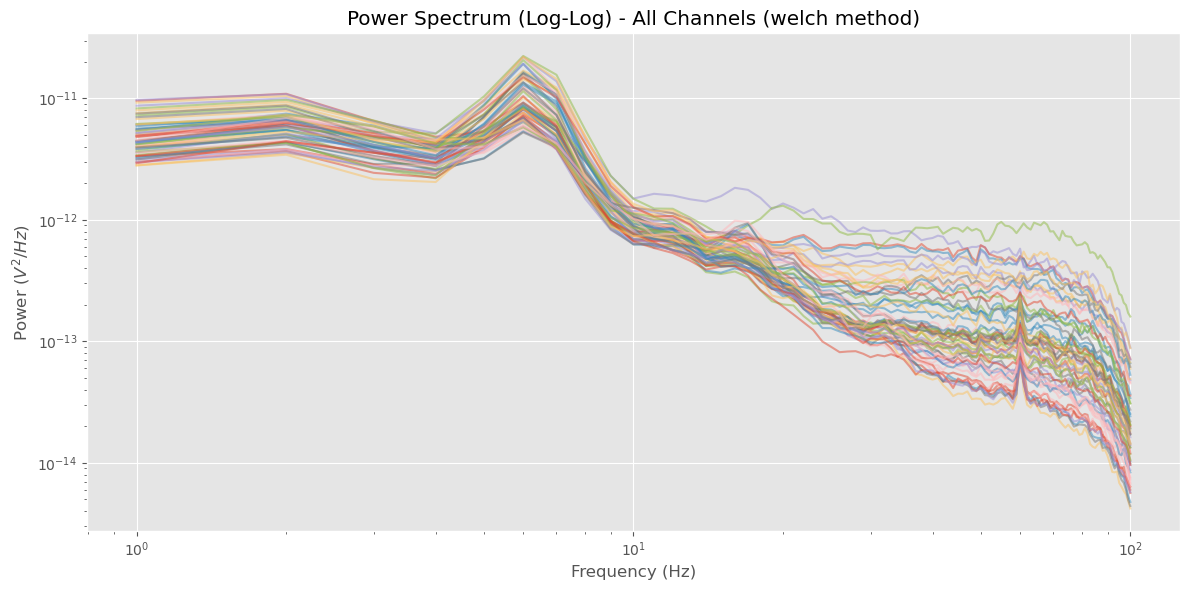

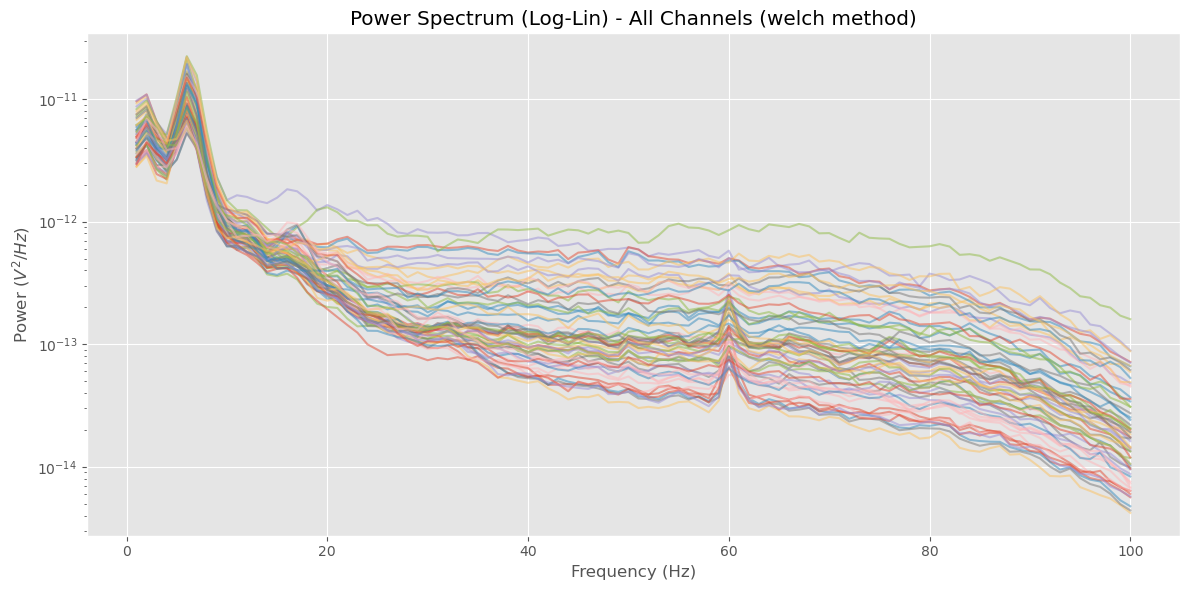

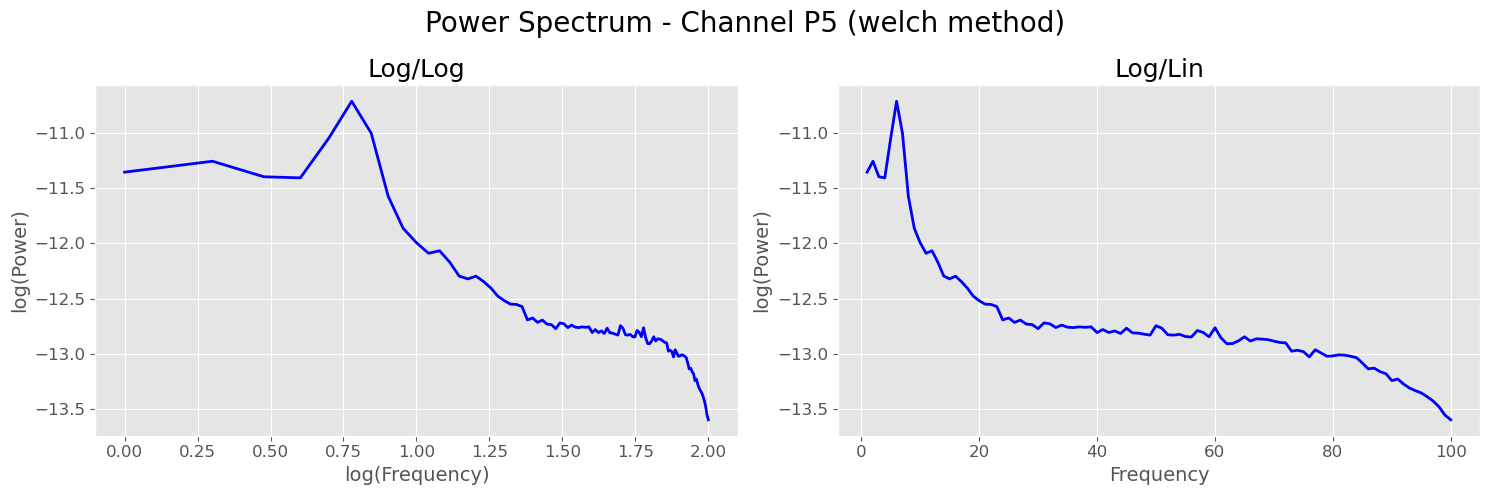

---EEG Spectral Parameterisation------------------------------------


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
Group Summary: SPM_fit_quality_warning       False
spectra_count                    63
null_fits                         0
r2_mean                    0.970338
peaks_mean                 3.444444
dtype: object
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                          

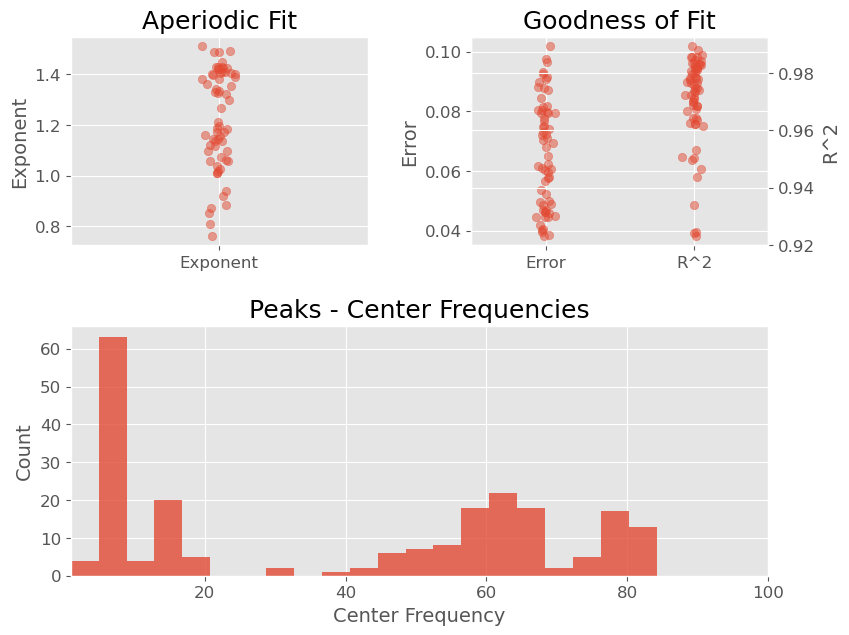

SpecParam for Channel: P5
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.9968, 1.1375                                         
                                                                                                  
                                       2 peaks were found:                         

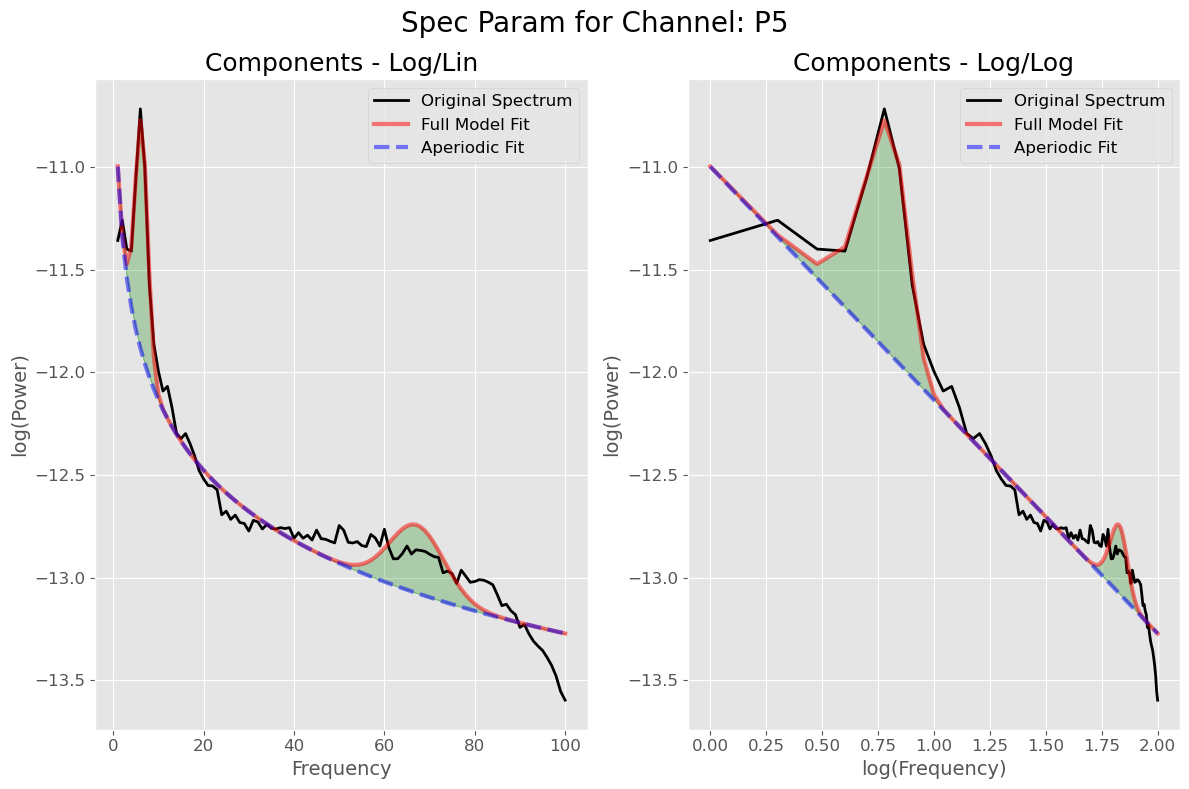

---Collating Results for sub-002 ------------------------------

-----------------------------------------------------------------------------------------------
Subject: sub-026
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-026/eeg/sub-026_task-Rest_eeg.fdt
Reading 0 ... 71409  =      0.000 ...   142.818 secs...
Description: None on None
<RawEEGLAB | sub-026_task-Rest_eeg.fdt, 63 x 71410 (142.8 s), ~34.4 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, Iz, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
Raw EEG Signal


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_96860/988434826.py:46: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


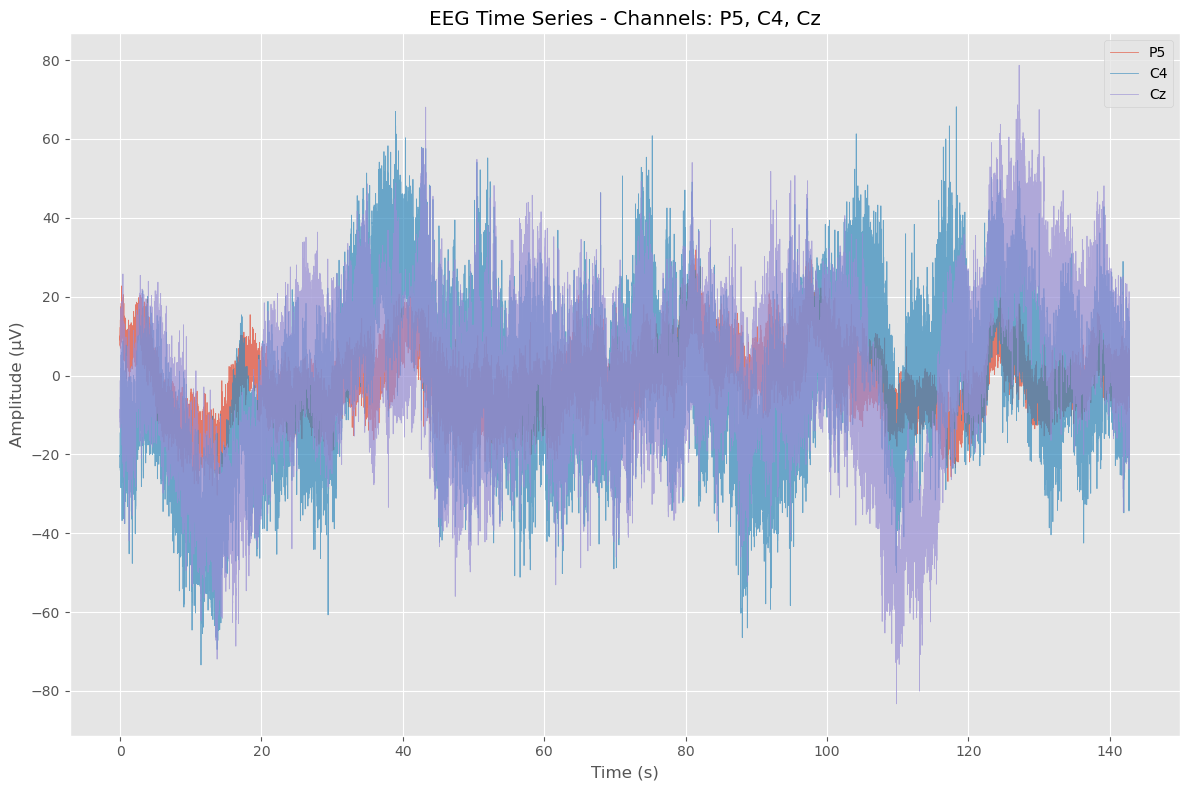

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'FT9', 'Fpz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO3', 'PO4', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: ['I1', 'I2']
Number of channels before: 63 and after montage set: 61


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    2.2s finished


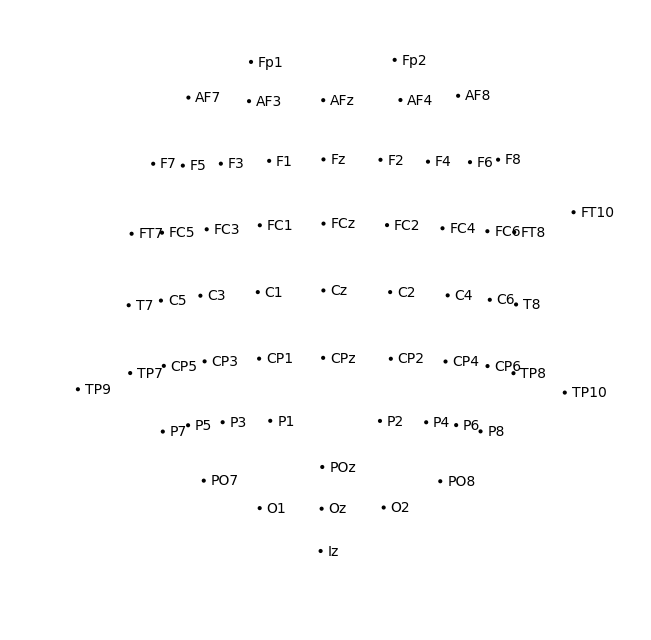

Filtered EEG Signal


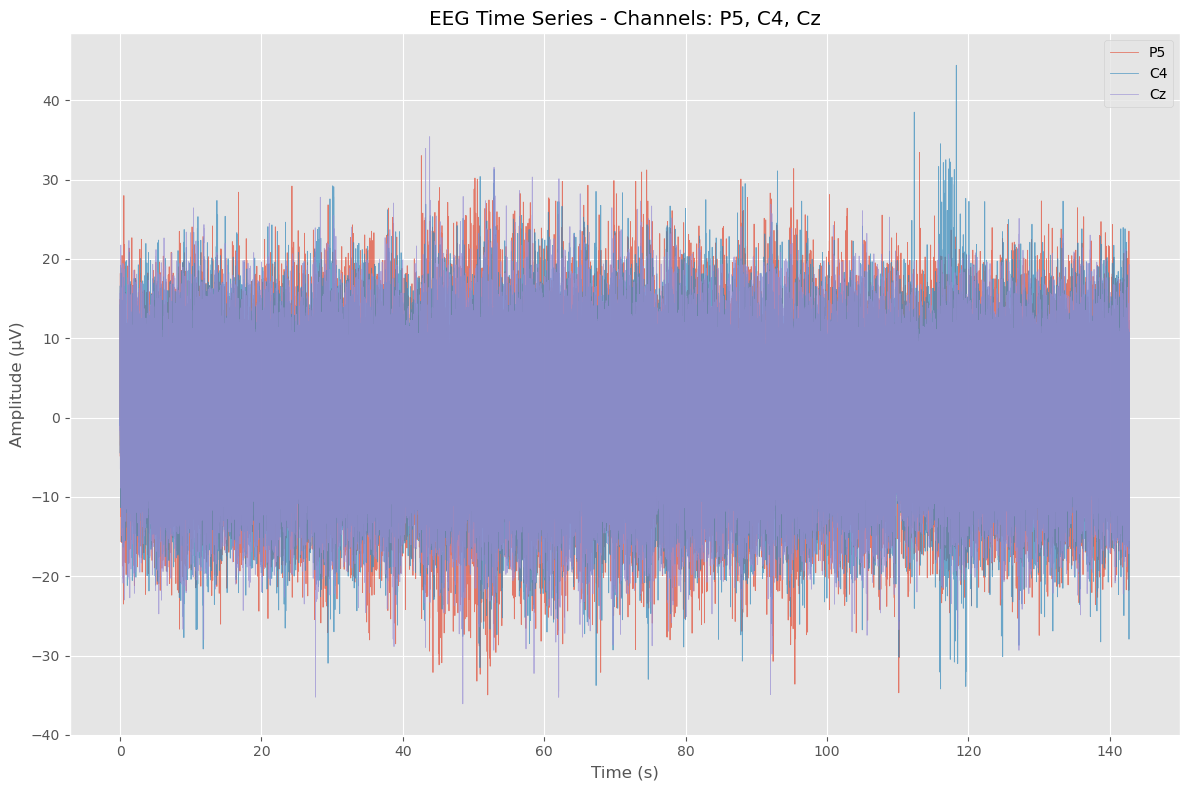

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 60 components
Computing Extended Infomax ICA
Fitting ICA took 96.8s.
Applying ICA to Raw instance
    Transforming to ICA space (60 components)
    Zeroing out 37 ICA components
    Projecting back using 61 PCA components
ICA Components Breakdown
Original Channels: 61. ICA Components: 60
Brain Components: 23, 38.33%
Other Components: 37, 61.67%
List of Brain components: [2, 5, 6, 7, 9, 11, 12, 13, 14, 18, 22, 23, 28, 29, 34, 35, 38, 43, 51, 55, 56, 57, 59]
Component 0 contribution:   eeg: 87.29%
Component 1 contribution:   eeg: 5.30%
Component 2 contribution:   eeg: 2.40%
Component 3 contribution:   eeg: 0.66%
Component 4 contribution:   eeg: 0.54%
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 500 original tim

  0%|          | Creating augmented epochs : 0/61 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/61 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

  0%|          | Fold : 0/3 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=16


  0%|          | Repairing epochs : 0/114 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Epochs rejected: 0 out of 114, 0.00%


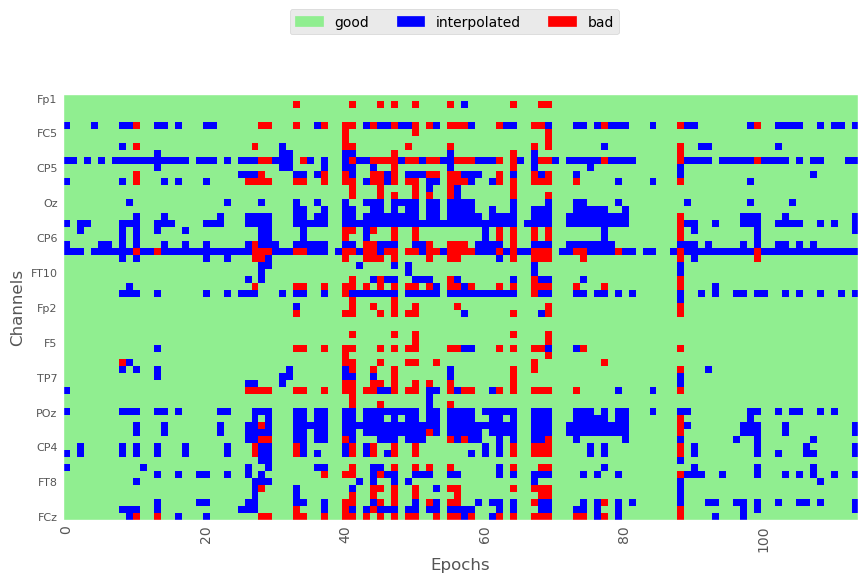

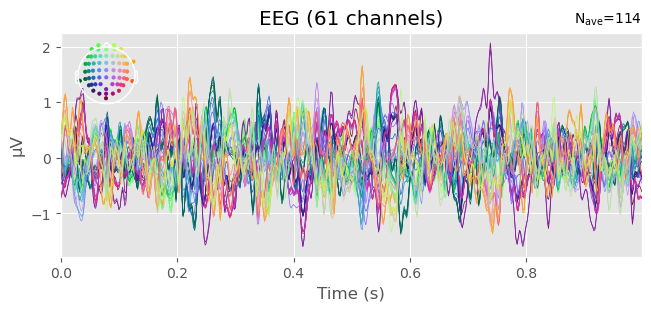

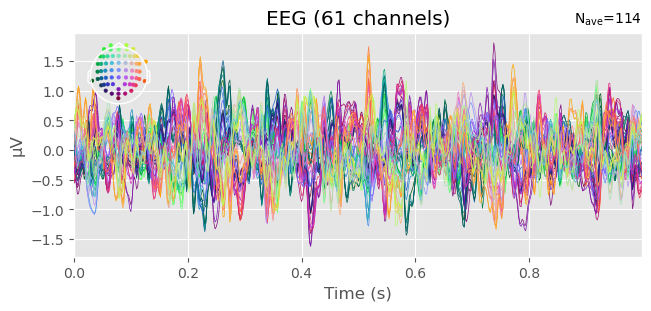

EEG Post Artifact Removal
<Epochs | 114 events (all good), 0 – 0.998 s (baseline off), ~26.6 MiB, data loaded,
 '1': 114>
Temp .... <Epochs | 114 events (all good), 0 – 0.998 s (baseline off), ~26.6 MiB, data loaded,
 '1': 114>, 
EEG_processing_quality_warning       False
channel_count                           61
ICA_components_count                    60
ICA_rejection_level               0.616667
epochs_count                           114
epoch_rejection_level                  0.0
dtype: object
---Power Spectra----------------------------------------------------
Effective window size : 1.000 (s)
<Averaged Power Spectrum (from Epochs, welch method) | 61 channels × 100 freqs, 1.0-100.0 Hz>
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, Iz, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 61 EEG
 custom_ref_applied: True
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>


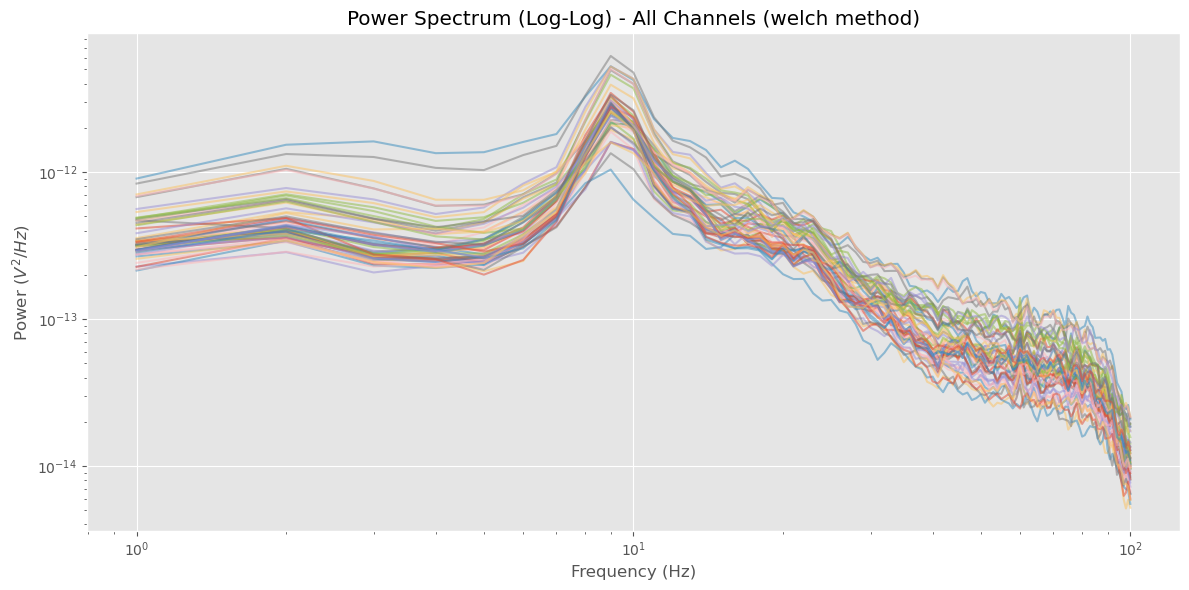

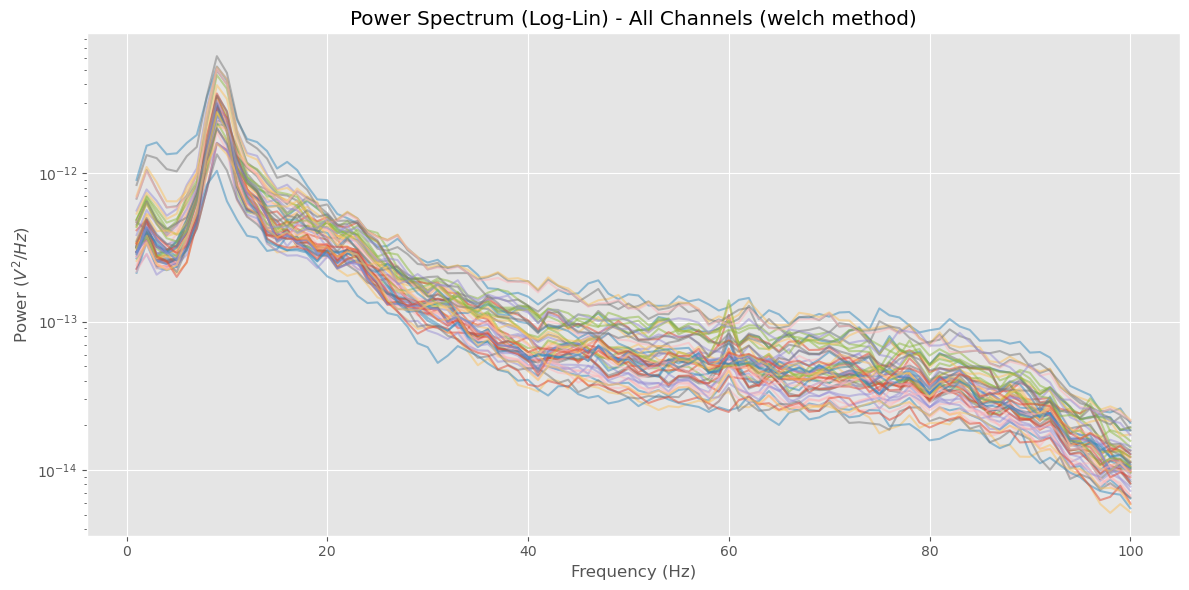

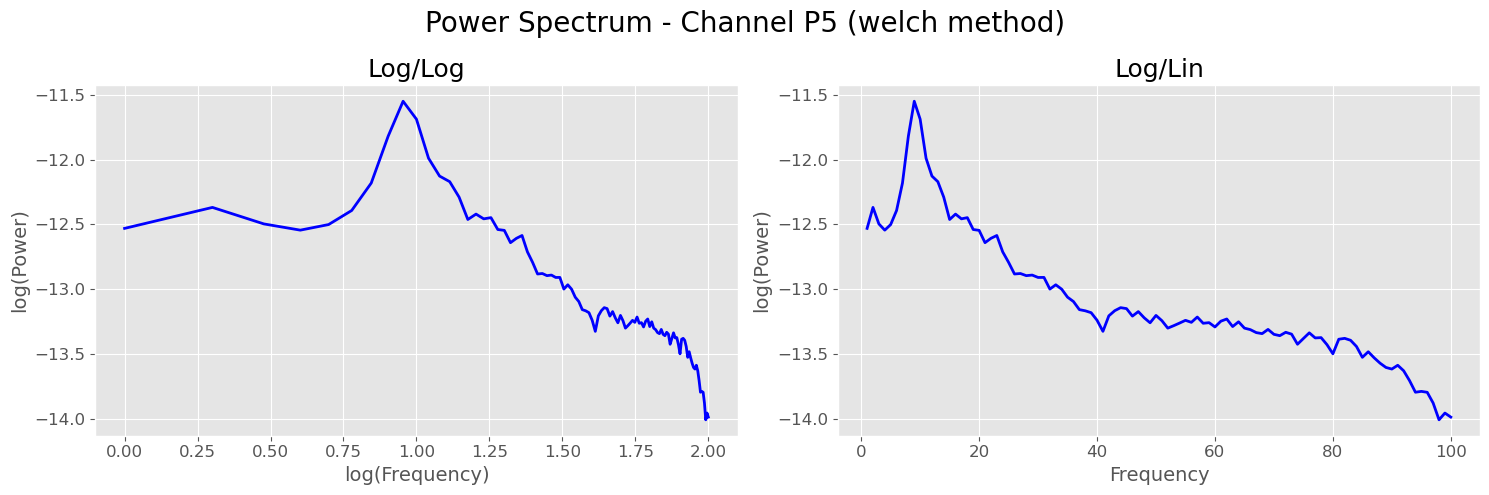

---EEG Spectral Parameterisation------------------------------------


Running group fits.:   0%|          | 0/61 [00:00<?, ?it/s]


	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Executed Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.1, peak_threshold=2.0, aperiodic_mode='fixed')
Group Summary: SPM_fit_quality_warning       False
spectra_count                    61
null_fits                         0
r2_mean                    0.937408
peaks_mean                 3.655738
dtype: object
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 61                          

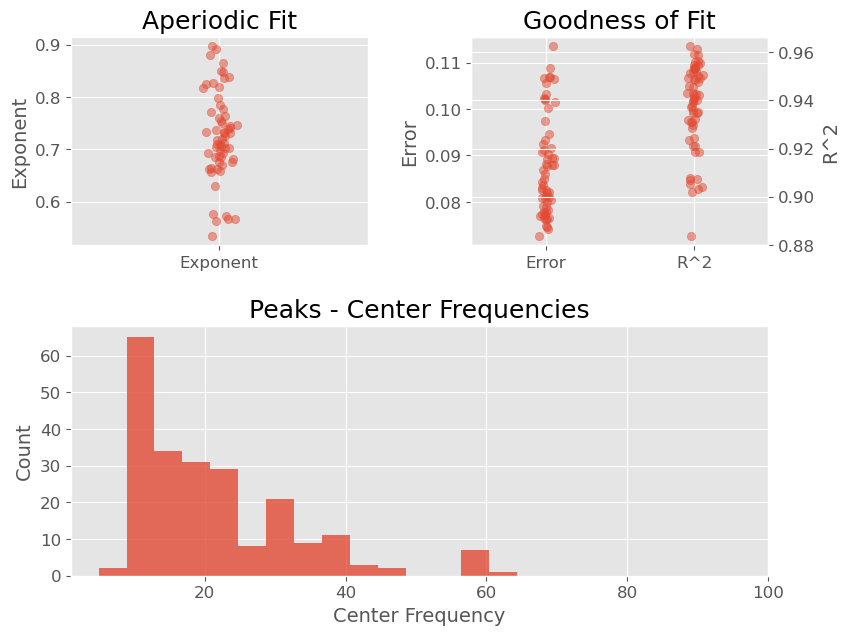

SpecParam for Channel: P5
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -12.1638, 0.6850                                         
                                                                                                  
                                       4 peaks were found:                         

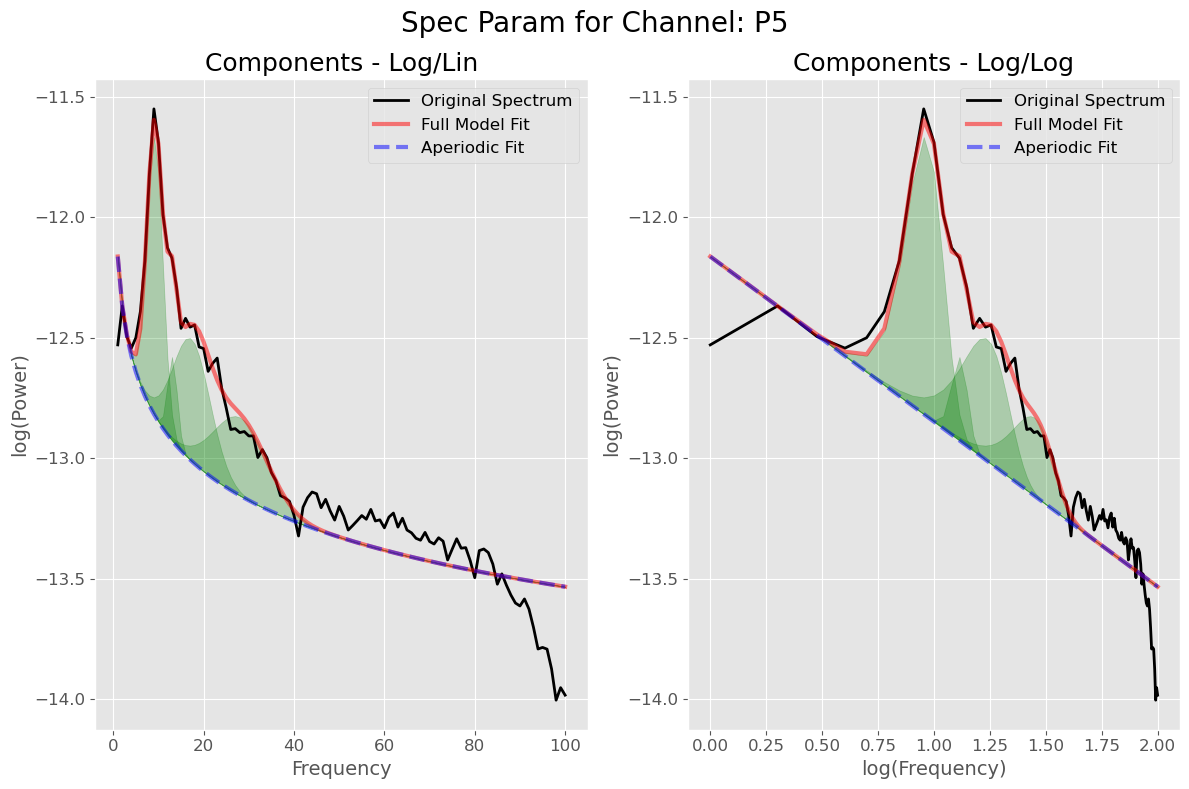

---Collating Results for sub-026 ------------------------------


In [17]:
# Execute all the EEG processing steps for each subject
#

summary = f'EEG Processing for: {study_name} {dataset_ref}. Run: {run_name}'
summary = summary + f'\n- Preprocessing Params: {preprocess_params}'
summary = summary + f'\n- Artefact Removal Params: {artefact_params}'
summary = summary + f'\n- PSD Params: {psd_params}'
summary = summary + f'\n- Specparam Params: {specparam_params}'
print(summary)

# Initialize AutoReject
# TODO: Which initiailisation to use?
ar_model = AutoReject(cv=3, n_interpolate=[1, 4, 8, 16], consensus=[0.5, 1], random_state=313, n_jobs=-1,
                thresh_method='bayesian_optimization', verbose=VERBOSE)
# ar_model = AutoReject(n_interpolate=[1, 2, 4], random_state=42, n_jobs=-1, verbose=VERBOSE)

# Loop through all subjects in the study
for idx, subject in study_subjects_df.iterrows():

    # Just sample a subset of subjects when in test mode
    # NB: For subject samples, keep a copy of EEG raw and processed files, eg to inspect
    if test_mode and idx not in test_subjects:
        continue

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Subject: {subject_id}')

    # 1. EEG Raw Dataset Load
    #
    print('---Get EEG Raw Data - FIF -----------------------------------------')
    EEG_raw_files = get_EEG_raw(dataset_path, subject_id)
    # TODO: How to handle multiple session EEG raw files?
    temp_EEG_raw = EEG_raw_files[0]
    if test_mode:
        save_EEG_for_subject(temp_EEG_raw, eeg_processing_run_path, subject_id, tag='source')

    if VERBOSE:
        print(f"Description: {temp_EEG_raw.info['description']} on {temp_EEG_raw.info['meas_date']}")
        print(temp_EEG_raw)
        print(temp_EEG_raw.info)
        print_with_pdf('Raw EEG Signal', results_pdf)
        plot_EEG_TD(temp_EEG_raw, test_channels, pdf_file=results_pdf)

    # 2. EEG Filtering & Referencing
    #
    print('---Filtering & Referencing------------------------------------------')
    temp_EEG_filtered = perform_EEG_filtering(preprocess_params, temp_EEG_raw)
    if test_mode:
        save_EEG_for_subject(temp_EEG_filtered, eeg_processing_run_path, subject_id, tag='filtered')

    if VERBOSE:
        # TODO: Any need to summarise or retain results?
        print_with_pdf('Filtered EEG Signal', results_pdf)
        plot_EEG_TD(temp_EEG_filtered, test_channels, pdf_file=results_pdf)
    
    # 3. Artefact Removal with ICA
    #
    print('---Artefact Removal - ICA ------------------------------------------')
    artefact_results, temp_EEG_cleaned = perform_artefact_removal(artefact_params, temp_EEG_filtered)
    # TODO: Save rejections levels for later use and subject exclusion
    if test_mode:
        save_EEG_for_subject(temp_EEG_cleaned, eeg_processing_run_path, subject_id, tag='cleaned', epoched=True)

    if VERBOSE:
        # TODO: Any need to summarise or retain results?
        # TODO: Correct plot for Epoched data
        # plot_EEG_TD(temp_EEG_cleaned, test_channels, pdf_file=results_pdf)
        print(f'Temp .... {temp_EEG_cleaned}, \n{artefact_results}')

    # 4. Power Spectra
    #
    print('---Power Spectra----------------------------------------------------')
    temp_spectra = get_spectra(psd_params, temp_EEG_cleaned)
    if test_mode:
        psd_save_path = os.path.join(eeg_processing_run_path, f'{subject_id}_psd.npy')
        np.save(psd_save_path, temp_spectra.get_data())
    
    if VERBOSE:
        # print(f'Using parameters: {psd_params}')
        print(temp_spectra)
        print(temp_spectra.info)
        plot_EEG_PSD(temp_spectra, test_channels[0])
        # plot_EEG_PSD(temp_spectra, test_channels[1])

    # 5. Spectral Parameterisation
    #
    print('---EEG Spectral Parameterisation------------------------------------')
    group_summary, specparam_df, fg = perform_SpecParam(specparam_params, temp_spectra)
    if test_mode:
        fg.save_report(f'{subject_id}_specparam', eeg_processing_run_path)
    
    if VERBOSE:
        print(f'Executed Settings: {fg.get_settings()}')
 
        # Overall group results
        print(f'Group Summary: {group_summary}')
        fg.print_results()
        fg.plot()
        plt.show()

        # Plot the test channels
        channel_idx = temp_spectra.ch_names.index(test_channels[0])
        plot_SpecParam(fg, channel_idx, test_channels[0])

    # Results Superset add to the overall study results dataframe
    print(f'---Collating Results for {subject_id} ------------------------------')
    subject_results_df = subject_results_combine(subject, artefact_results, group_summary, specparam_df)
    eeg_results_superset_df = pd.concat([eeg_results_superset_df, subject_results_df], ignore_index=True)

    # TODO: Combine subject results eg total averaged, by region etc .... ??

# Save results
eeg_results_superset_df.to_pickle(eeg_processing_run_path + '/eeg_results_superset_df.pkl', compression='zip')

results_pdf.close()


# Inspections

In [18]:
# filtered = get_spectra(psd_params, temp_EEG_filtered)
# cleaned = get_spectra(psd_params, temp_EEG_cleaned)

# plot_EEG_PSD(filtered, 'C4')
# plot_EEG_PSD(cleaned, 'C4')